### Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!pip install torchviz

In [3]:
!pip install graphviz

In [4]:
import math
import numpy as np
import cv2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
import torchvision.transforms.functional as F_t
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
from IPython import display

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super().__init__()
        B = torch.randn(in_features, out_features)*scale
        self.register_buffer("B", B)
    
    def forward(self, x):
        x_proj = torch.matmul(2*math.pi*x, self.B)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

In [8]:

class SignalRegressor(nn.Module):
    def __init__(self, in_features, fourier_features,
                 hidden_features, hidden_layers, out_features, scale):
        super().__init__()

        self.net = []
        if fourier_features is not None:
            self.net.append(FourierLayer(in_features, fourier_features, scale))
            self.net.append(nn.Linear(2*fourier_features, hidden_features))
            self.net.append(nn.ReLU())
        else:
            self.net.append(nn.Linear(in_features, hidden_features))
            self.net.append(nn.ReLU())
        
        for i in range(hidden_layers-1):
            self.net.append(nn.Linear(hidden_features, hidden_features))
            self.net.append(nn.ReLU())

        self.net.append(nn.Linear(hidden_features, out_features))
        self.net.append(nn.Sigmoid())
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        out = self.net(x)
        return out

In [9]:
class ImageDataset(Dataset):
    def __init__(self, image_path):
        super().__init__()
        self.image_path = image_path

    def __getitem__(self, idx):
        image = read_image(self.image_path)
        
        image_reduced = cv2.resize(image.permute(1, 2, 0).cpu().numpy(), dsize=(int(image.permute(1, 2, 0).shape[1]/2),int(image.permute(1, 2, 0).shape[0]/2)), interpolation=cv2.INTER_CUBIC)
        image_augmented = cv2.resize(image_reduced, dsize=(int(image.permute(1, 2, 0).shape[1]),int(image.permute(1, 2, 0).shape[0])), interpolation=cv2.INTER_CUBIC) 

        #print(image_augmented.shape)
        
        image = F_t.convert_image_dtype(image, dtype=torch.float)
        image = image.permute(1, 2, 0)
        
        h_axis = torch.linspace(0, 1, steps=image.shape[0])
        w_axis = torch.linspace(0, 1, steps=image.shape[1])
        grid = torch.stack(torch.meshgrid(h_axis, w_axis), dim=-1)

        image_reduced = torch.from_numpy(image_reduced) 
        image_augmented = torch.from_numpy(image_augmented)

        h_axis_reduced = torch.linspace(0, 1, steps=image_reduced.shape[0])
        w_axis_reduced = torch.linspace(0, 1, steps=image_reduced.shape[1])
        grid_reduced = torch.stack(torch.meshgrid(h_axis_reduced, w_axis_reduced), dim=-1)

        image_reduced = F_t.convert_image_dtype(image_reduced, dtype=torch.float)
        image_augmented = F_t.convert_image_dtype(image_augmented, dtype=torch.float)            

        return grid, image, grid_reduced, image_reduced, image_augmented
    
    def __len__(self):
        return 1

In [10]:
web_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Lego_Color_Bricks.jpg/320px-Lego_Color_Bricks.jpg"
download_url(web_url, ".", "lego.jpg")

Using downloaded and verified file: ./lego.jpg


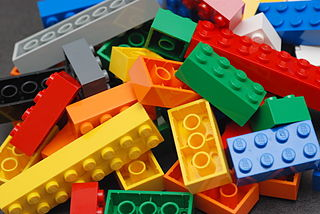

In [11]:
image_path = "lego.jpg"
display.Image(image_path)

In [12]:
image_data = ImageDataset(image_path)
image_loader = DataLoader(image_data, batch_size=1)

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step: 100, Test PSNR: 12.500099


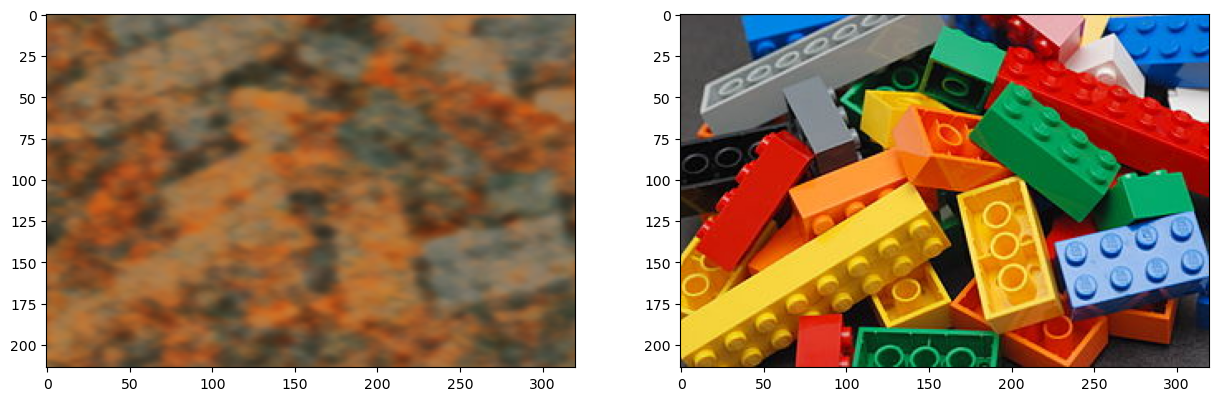

Step: 200, Test PSNR: 20.352779


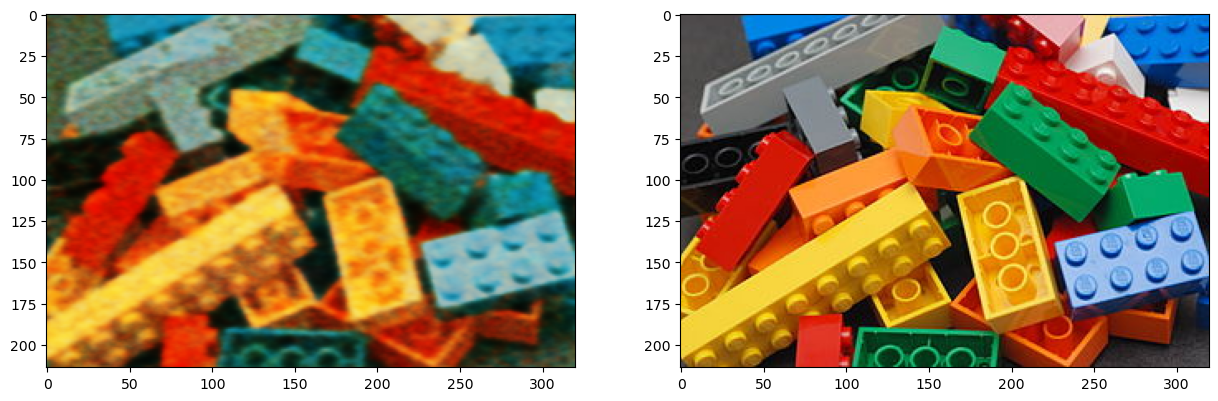

Step: 300, Test PSNR: 23.394962


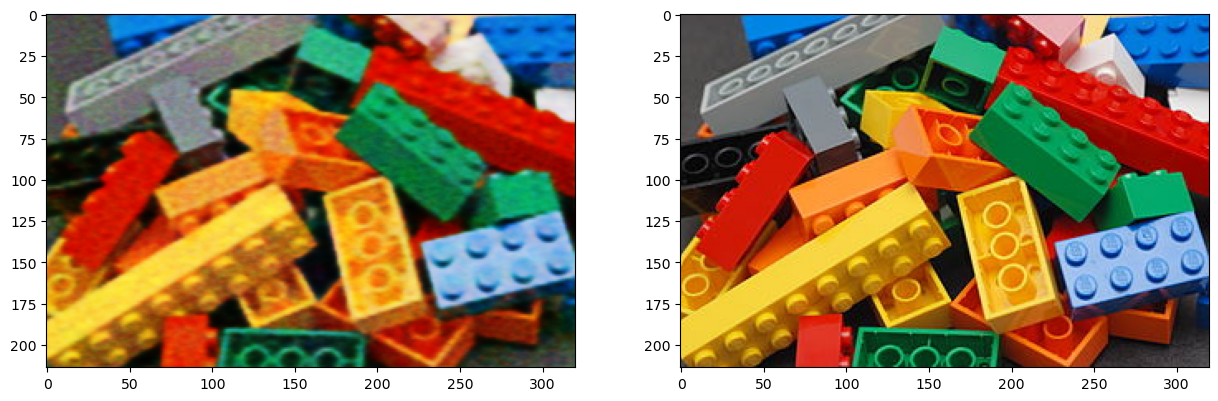

Step: 400, Test PSNR: 24.520550


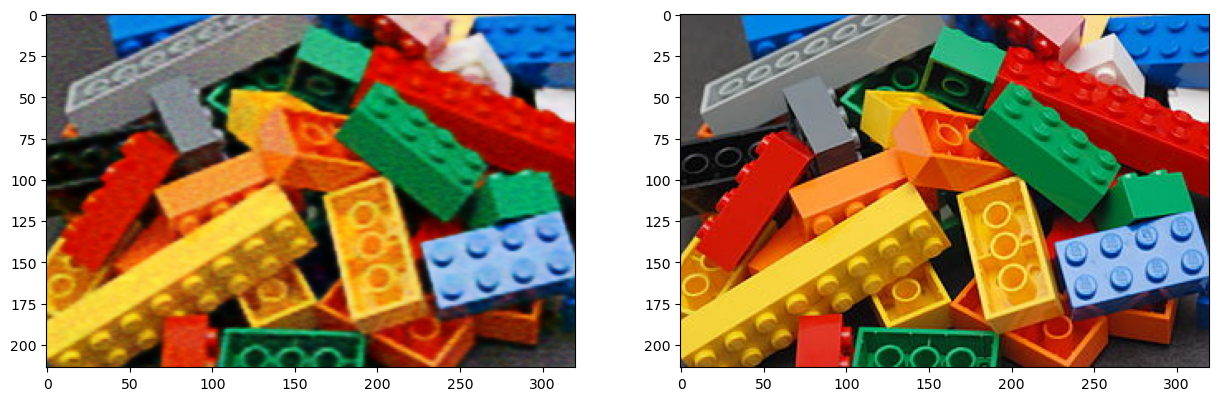

Step: 500, Test PSNR: 25.042530


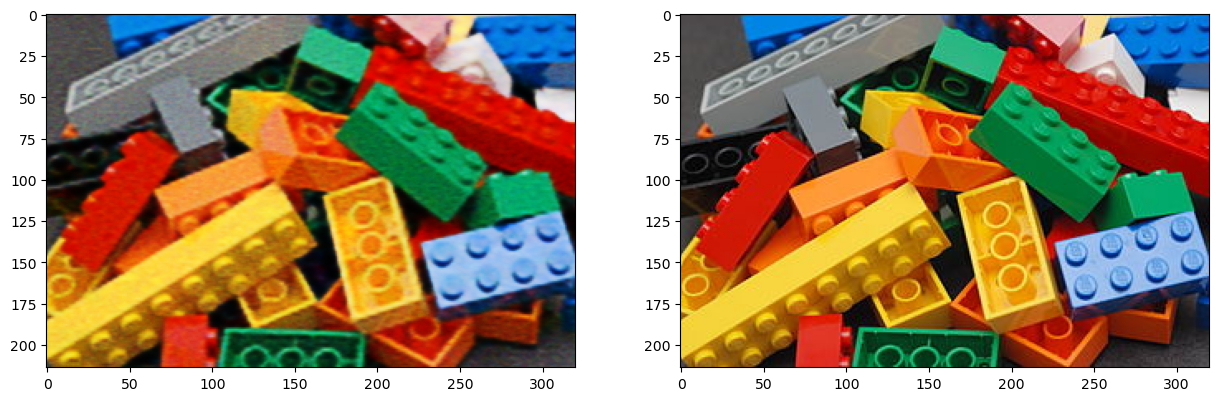

Step: 600, Test PSNR: 25.306303


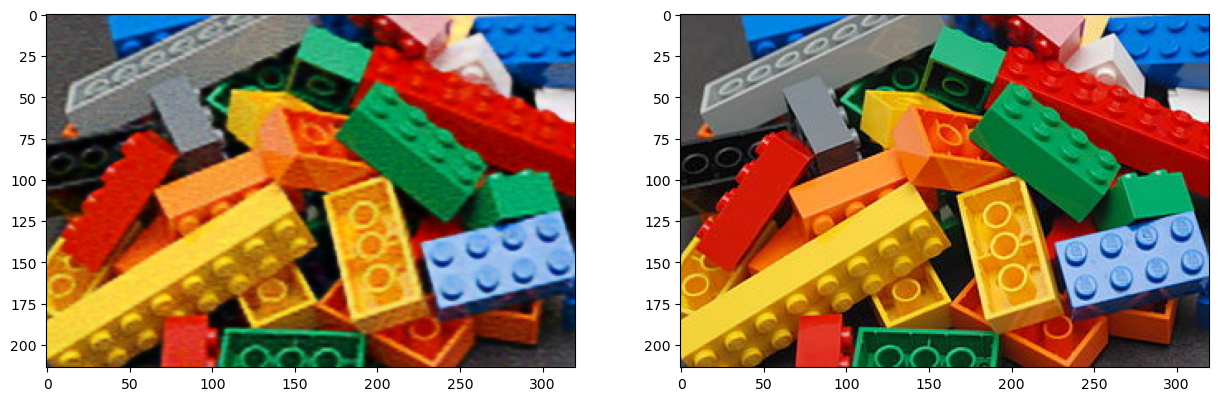

Step: 700, Test PSNR: 25.436634


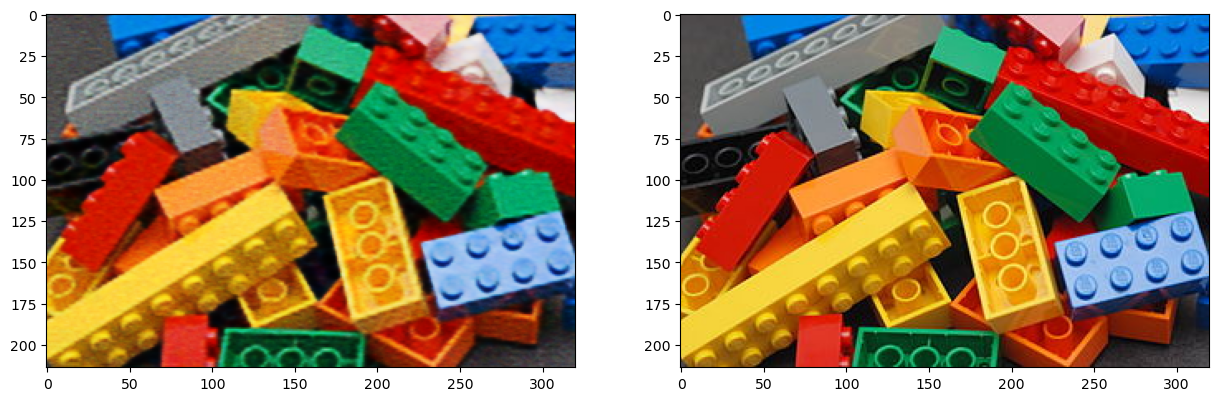

Step: 800, Test PSNR: 25.506386


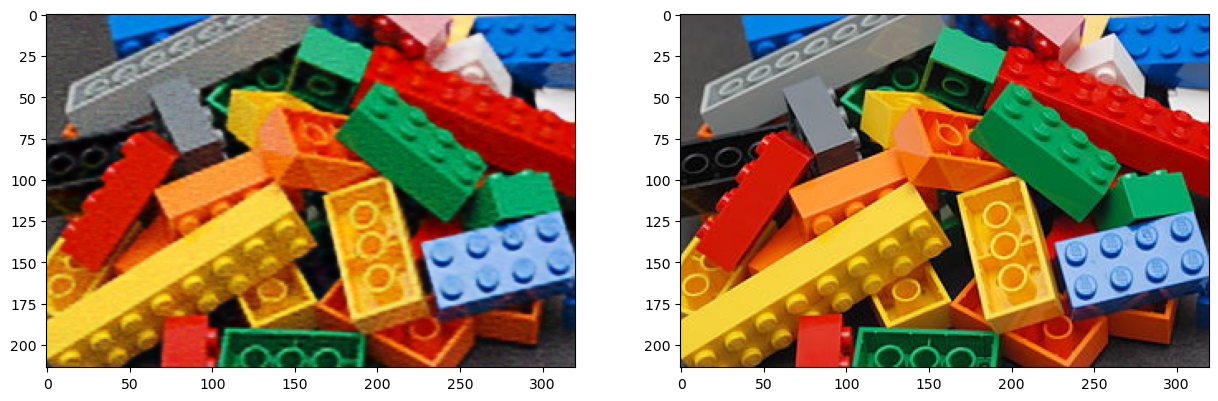

Step: 900, Test PSNR: 25.562170


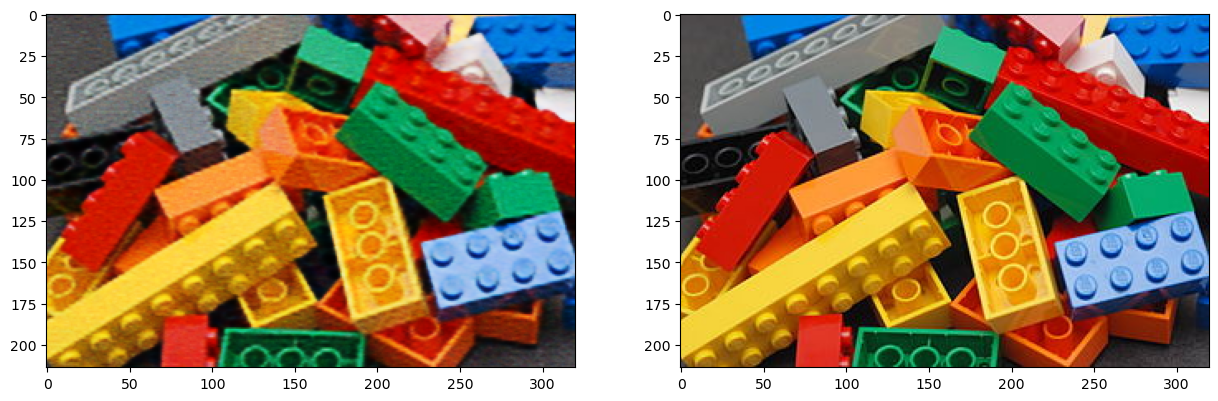

Step: 1000, Test PSNR: 25.590086


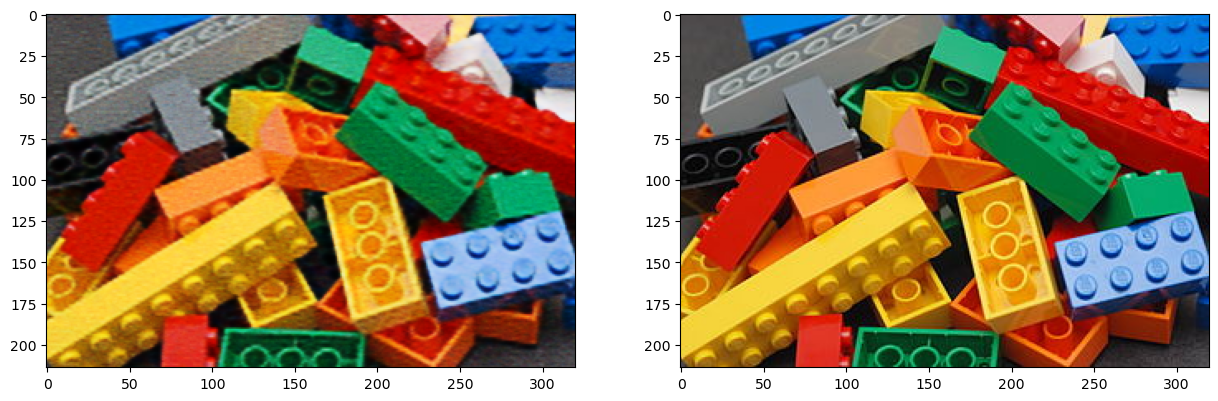

In [13]:
SEED = 3    
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


total_steps = 1000
summary_interval = 100

grid, image, grid_reduced, image_reduced, image_augmented = next(iter(image_loader))
grid, image, grid_reduced, image_reduced, image_augmented = grid.squeeze().to(device), image.squeeze().to(device), grid_reduced.squeeze().to(device), image_reduced.squeeze().to(device), image_augmented.squeeze().to(device)
#train_coords, train_rgbs = grid[::2, ::2].reshape(-1, 2), image[::2, ::2].reshape(-1, 3)  # use every other pixel for training
#train_coords, train_rgbs = grid.reshape(-1, 2), image.reshape(-1, 3)  # use all the pixels for training
train_coords, train_rgbs = grid_reduced.reshape(-1, 2), image_reduced.reshape(-1, 3)  # use pixels from downsamples image for training
test_coords, test_rgbs = grid.reshape(-1, 2), image.reshape(-1, 3)  # use all the pixels for evaluation
test_rgbs_aug = image_augmented.reshape(-1, 3)  

#print(test_rgbs_aug.shape)
#sys.exit()

test_idea = False
if test_idea:
    print(grid.shape)
    print(image.shape)
    print(train_coords.shape)
    print(train_rgbs.shape)
    print(test_coords.shape)
    print(test_rgbs.shape)
    
    print()
    #image_reduces_x2 = torch.nn.functional.interpolate(image, scale_factor=(0.5))
    #image_reduces_x2 = torchvision.transforms.functional.resize(image, size=(image.shape[0]/2,image.shape[1]/2, 3), )
    """
    image_numpy = image.cpu().numpy()
    image_pil = Image.fromarray(np.uint8(image_numpy*255))
    image_reduced_x2_true = image_reduced_x2.resize(((int(image.shape[1]/2),int(image.shape[0]/2))))
    image_augmented_x2_true = image_reduced_x2_true.resize(((int(image.shape[1]),int(image.shape[0]))))
    print(image_reduced_x2.size)    
    print(image_reduced_x2_true.size)
    fig, axes = plt.subplots(2, 2, figsize=(15, 5))
    axes[0,0].imshow(image_reduced_x2)
    axes[0,1].imshow(image.cpu())
    axes[1,0].imshow(image_reduced_x2_true)    
    axes[1,1].imshow(image_augmented_x2_true)
    plt.show()
    """

    """
    image_reduced = cv2.resize(image.cpu().numpy(), dsize=(int(image.shape[1]/2),int(image.shape[0]/2)), interpolation=cv2.INTER_CUBIC)
    image_augmented = cv2.resize(image_reduced, dsize=(int(image.shape[1]),int(image.shape[0])), interpolation=cv2.INTER_CUBIC)
    
    print(image_reduced.size)    
    #print(image_reduced_x2_true.size)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 5))
    axes[0,0].imshow(image_reduced)
    axes[0,1].imshow(image.cpu())
    axes[1,1].imshow(image_augmented)
    plt.show()
    sys.exit()
    """

image_regressor = SignalRegressor(in_features=2, fourier_features=256,
                                  hidden_features=256, hidden_layers=4, out_features=3, scale=10).to(device)
optim = torch.optim.Adam(lr=1e-4, params=image_regressor.parameters())

for step in range(1, total_steps+1):
    image_regressor.train()
    optim.zero_grad()
    output = image_regressor(train_coords)
    train_loss = F.mse_loss(output, train_rgbs)
    train_loss.backward()
    optim.step()

    if not step % summary_interval:
        image_regressor.eval()
        with torch.no_grad():
            prediction = image_regressor(test_coords)
            test_loss = F.mse_loss(prediction, test_rgbs)
            test_psnr = -10*torch.log10(test_loss)

            print(f"Step: {step}, Test PSNR: {test_psnr.item():.6f}")
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            axes[0].imshow(prediction.reshape_as(image).cpu())
            axes[1].imshow(image.cpu())
            plt.show()


psnr_ffnetSR_HR = -10*torch.log10(F.mse_loss(prediction, test_rgbs))
psnr_ffnetSR_bicubic_SR = -10*torch.log10(F.mse_loss(prediction, test_rgbs_aug))
psnr_bicubic_HR = -10*torch.log10(F.mse_loss(test_rgbs_aug, test_rgbs))

In [14]:
print("Summary:")
print("PSNR SR-FFNet / HR: \t\t", psnr_ffnetSR_HR)
print("PSNR SR-FFNet / SR-Bicubic: \t", psnr_ffnetSR_bicubic_SR)
print("PSNR SR-FFNet / HR: \t\t", psnr_bicubic_HR)

Summary:
PSNR SR-FFNet / HR: 		 tensor(25.5901, device='cuda:0')
PSNR SR-FFNet / SR-Bicubic: 	 tensor(28.0250, device='cuda:0')
PSNR SR-FFNet / HR: 		 tensor(28.0285, device='cuda:0')


In [15]:
# https://github.com/fmu2/realNVP/blob/master/train.py